# Neural Network Mortgage Prepayment Model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import time
import imp
import os
import os, os.path
import datetime as dt
import dateutil.parser as dp
import dill
import datetime as dt

%matplotlib inline

## Load data from csv files in the ./data directory

In [ ]:
if True:
    # load data from csv files
    df = pd.DataFrame()
    for root, dirs, files in os.walk("../30y fixed rate data/fnm/conforming/clean data"):
        for name in files:
            file_name = os.path.join(root, name)
            if 'pools_part' in file_name:
                print(file_name)
                if len(df) > 0:
                    df = pd.concat([df,pd.read_csv(file_name)])
                else:
                    df = pd.read_csv(file_name)        

    model_name = 'nn-ppm-from-csv.h5' # for saving a model later

else:
    dill.load_session('notebook_env_all_3_dfs.db')

    print('Loaded data as is:')
    print('attr_df.shape   = ', attr_df.shape)
    print('geo_df.shape    = ', geo_df.shape)
    print('seller_df.shape = ', seller_df.shape)

    nloans = 250
    attr_df = attr_df[attr_df['cnloans']>=nloans]

    print('Data size after filtering for >= 250 loans:')
    print(f'attr_df.shape = {attr_df.shape}')

    geo_df.drop('poolno',axis=1,inplace=True)
    df = pd.merge(attr_df,geo_df,on=['cusip','asofdate'],how='left')

    seller_df.drop('poolno',axis=1,inplace=True)
    df = pd.merge(df,seller_df,on=['cusip','asofdate'],how='left')

    df.fillna(0,inplace=True)

    model_name = 'nn-ppm-dill-data.h5' # for saving a model later

df['Seasonality'] = df['asofdate'].apply(lambda x: int(str(x)[-2:]))

print('df.shape = ', df.shape)

### Make sure all the fields (except cusip and poolsno) are numerical and there are no NAs

In [2]:
df = pd.read_pickle("../conv_30yr.pkl")

In [12]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12954704 entries, 0 to 29999
Data columns (total 121 columns):
 #   Column              Non-Null Count     Dtype  
---  ------              --------------     -----  
 0   poolno              12954704 non-null  object 
 1   asofdate            12954704 non-null  int64  
 2   cusip               12954704 non-null  object 
 3   spread              12954704 non-null  float64
 4   SMM                 12954704 non-null  float64
 5   DayCount            12954704 non-null  float64
 6   OBal                12954704 non-null  float64
 7   CBal                12954704 non-null  float64
 8   factor              12954704 non-null  float64
 9   Coupon              12954704 non-null  float64
 10  Wac                 12954704 non-null  float64
 11  Wam                 12954704 non-null  float64
 12  Age                 12954704 non-null  float64
 13  aols                12954704 non-null  float64
 14  waols               12954704 non-null  float64
 15

In [4]:
df.head()

,poolno,asofdate,cusip,spread,SMM,DayCount,OBal,CBal,factor,Coupon,...,SellerPct_NATIONST,SellerPct_NRESM,SellerPct_PNYMAC,SellerPct_PILOSI,SellerPct_QUICK,SellerPct_REG,SellerPct_RMSC,SellerPct_UNSHFI,SellerPct_WFHM,Seasonality
0,877118,201012,31409SPB0,-19.5,0.0029,22.0,58535566.0,58449322.63,99.852665,3.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12
1,877118,201101,31409SPB0,-44.0,0.0247,20.0,58535566.0,58350056.36,99.683082,3.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,877118,201102,31409SPB0,-66.8,0.1765,19.0,58535566.0,58162116.05,99.362012,3.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,877118,201103,31409SPB0,-78.7,0.8830,23.0,58535566.0,57564063.94,98.340322,3.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
4,877118,201104,31409SPB0,-82.7,1.0095,21.0,58535566.0,56898607.41,97.203480,3.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [ ]:
# df.to_pickle('../conv_30yr.pkl')

In [5]:
print('df.shape = ', df.shape)

df.shape =  (12954704, 111)


## Model features selection and defining train/test split

* In this section we select which features (columns) are to be used in the model and define a test-train split. 

In [6]:
dummies = pd.get_dummies(df['Seasonality'],drop_first=True)
df = df.drop('Seasonality',axis=1)
df = pd.concat([df,dummies],axis=1)

print(f'df.shape = {df.shape}')

df.shape = (12954704, 121)


In [16]:
list(dummies.columns)

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [17]:
model_columns = ['asofdate',
                 'SMM',
                 'spread',
                 'DayCount','factor',
                 'Wac','Wam','Age','aols','waols','CSato',
                 'oltv','cltv','ocltv','ccltv',
                 'fico',
                 '%CashWindow','%Majors',
                 'PurpPct_purchase','PurpPct_refi',
                 'PctChannel_Broker','PctChannel_Corr','PctChannel_Retail',
                 'OccPct_investor','OccPct_owner','PropUnitsPct_2-4',
                
                 # features showing geographical composition of a pool
                 'StatePct_AK','StatePct_AL','StatePct_AR','StatePct_AZ','StatePct_CA','StatePct_CO','StatePct_CT',
                 'StatePct_DC','StatePct_DE','StatePct_FL','StatePct_GA','StatePct_GU','StatePct_HI','StatePct_IA',
                 'StatePct_ID','StatePct_IL','StatePct_IN','StatePct_KS','StatePct_KY','StatePct_LA','StatePct_MA',
                 'StatePct_MD','StatePct_ME','StatePct_MI','StatePct_MN','StatePct_MO','StatePct_MS','StatePct_MT',
                 'StatePct_NC','StatePct_ND','StatePct_NE','StatePct_NH','StatePct_NJ','StatePct_NM','StatePct_NV',
                 'StatePct_NY','StatePct_OH','StatePct_OK','StatePct_OR','StatePct_PA','StatePct_PR','StatePct_RI',
                 'StatePct_SC','StatePct_SD','StatePct_TN','StatePct_TX','StatePct_UT','StatePct_VA','StatePct_VI',
                 'StatePct_VT','StatePct_WA','StatePct_WI','StatePct_WV','StatePct_WY',
                 
                 # features showing originator composition of a pool
                 'SellerPct_AMRHT','SellerPct_ALS','SellerPct_CAFULL','SellerPct_CNTL','SellerPct_CITIZ',
                 'SellerPct_53','SellerPct_FIR','SellerPct_FRDOM','SellerPct_GUILD','SellerPct_CHASE',
                 'SellerPct_LLSL','SellerPct_MATRX','SellerPct_NCM','SellerPct_NATIONST','SellerPct_NRESM',
                 'SellerPct_PNYMAC','SellerPct_PILOSI','SellerPct_QUICK','SellerPct_REG','SellerPct_RMSC',
                 'SellerPct_UNSHFI','SellerPct_WFHM'] + list(dummies.columns)

In [22]:
dfm = df[df['cnloans'] >= 500][model_columns]

print(f'dfm.shape = {dfm.shape}')

dfm.shape = (336825, 113)


In [23]:
# define train/test split
# from sklearn.model_selection import train_test_split

# X = dfm.drop(['SMM','asofdate'],axis=1)
# y = dfm['SMM'].values

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

data_cutoff = 202010

dfm_train = dfm[dfm['asofdate'] <  data_cutoff]
dfm_test  = dfm[dfm['asofdate'] >= data_cutoff]

X_train = dfm_train.drop(['SMM','asofdate'],axis=1).values
y_train = dfm_train['SMM'].values

X_test = dfm_test.drop(['SMM','asofdate'],axis=1).values
y_test = dfm_test['SMM'].values

print(f'X_train.shape = {X_train.shape}')
print(f'y_train.shape = {y_train.shape}')
print('\n')
print(f'X_test.shape  = {X_test.shape}')
print(f'y_test.shape  = {y_test.shape}')

X_train.shape = (332283, 111)
y_train.shape = (332283,)


X_test.shape  = (4542, 111)
y_test.shape  = (4542,)


## FF neural-network mortgage prepayment model

* In this section we fit the model to train data

In [24]:
# scale train/test data because buiding a neural net
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [25]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation,Dropout

C:\Users\YuriTurygin\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\YuriTurygin\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\YuriTurygin\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\YuriTurygin\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:5

In [26]:
model = Sequential()

#input layer / first hidden layer
model.add(Dense(512, input_dim=X_train.shape[1], activation='relu'))
#model.add(Dropout(0.3))
model.add(Dropout(0.5))

# hidden layers
model.add(Dense(256, activation='relu'))
#model.add(Dropout(0.3))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.3))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
# model.add(Dropout(0.5))

#output layer
model.add(Dense(1, activation='relu')) # no activation means linear activation a(x)=x
#model.add(Dense(1)) # no activation means linear activation a(x)=x

model.compile(optimizer='adam', loss='mse')
# model.compile(optimizer='rmsprop', loss='mse')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [27]:
model.fit(x=X_train,
          y=y_train,
          validation_data=(X_test,y_test),
          batch_size=1024,
          epochs=10)

Train on 332283 samples, validate on 4542 samples
Epoch 1/10
332283/332283 [==============================] - 6s 19us/sample - loss: 0.6812 - val_loss: 3.2517
Epoch 2/10
332283/332283 [==============================] - 6s 18us/sample - loss: 0.3911 - val_loss: 2.1582
Epoch 3/10
332283/332283 [==============================] - 6s 18us/sample - loss: 0.3440 - val_loss: 2.1140
Epoch 4/10
332283/332283 [==============================] - 6s 17us/sample - loss: 0.3237 - val_loss: 1.7203
Epoch 5/10
332283/332283 [==============================] - 6s 18us/sample - loss: 0.3082 - val_loss: 2.0252
Epoch 6/10
332283/332283 [==============================] - 6s 18us/sample - loss: 0.2966 - val_loss: 1.9316
Epoch 7/10
332283/332283 [==============================] - 6s 18us/sample - loss: 0.2889 - val_loss: 1.5001
Epoch 8/10
332283/332283 [==============================] - 6s 18us/sample - loss: 0.2840 - val_loss: 1.6720
Epoch 9/10
332283/332283 [==============================] - 6s 18us/sample - l

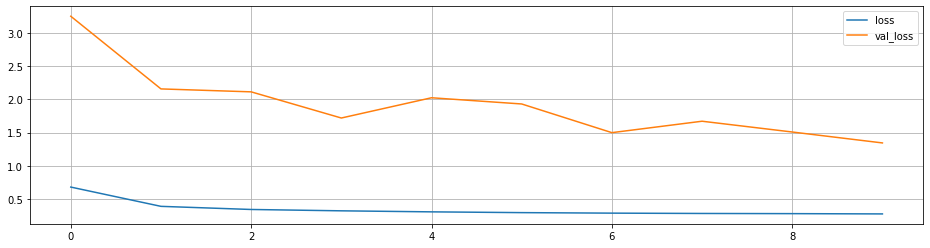

In [28]:
losses = pd.DataFrame(model.history.history)

losses.plot(figsize=(16,4),grid=True)

## Model Evaluation and Validation

* to be updated

### Validation reports

In [29]:
def valReport(dframe,graphTitle='',lcoup=2.5,hcoup=5,fsize=(24,24)):

    ppm_table = dframe[['CBal','model SMM x CBal','SMM x CBal','Coupon','ppmdate']].groupby(['Coupon','ppmdate']).sum()

    ppm_table['SMM'] = ppm_table['SMM x CBal']/ppm_table['CBal']
    ppm_table['CPR'] = 100*(1-(1-ppm_table['SMM']/100)**12)

    ppm_table['model SMM'] = ppm_table['model SMM x CBal']/ppm_table['CBal']
    ppm_table['model CPR'] = 100*(1-(1-ppm_table['model SMM']/100)**12)
    
    fig = plt.figure(figsize=fsize)
    
    plt.title(graphTitle)

    numOfsubgraphs = int((hcoup-lcoup)*2 + 1)

    for i in range(numOfsubgraphs):
        ax = fig.add_subplot(numOfsubgraphs,1,i+1)
        coupon = lcoup + i*0.5
        if ('CPR',coupon) in ppm_table.unstack(level=0).columns:
            ppm_table.unstack(level=0)[[('CPR',coupon),('model CPR',coupon)]].plot(ax=ax,grid=True)
            ax.legend()

In [30]:
def rmse_by_coupon(dframe,lcoup=2.5,hcoup=5,col_name='RMSE (CPR)'):
    
    ppm_table = dframe[['CBal','model SMM x CBal','SMM x CBal','Coupon','ppmdate']].groupby(['Coupon','ppmdate']).sum()

    ppm_table['SMM'] = ppm_table['SMM x CBal']/ppm_table['CBal']
    ppm_table['CPR'] = 100*(1-(1-ppm_table['SMM']/100)**12)

    ppm_table['model SMM'] = ppm_table['model SMM x CBal']/ppm_table['CBal']
    ppm_table['model CPR'] = 100*(1-(1-ppm_table['model SMM']/100)**12)
    
    RMSE_by_coupon = dict()
    
    for i in range(int((hcoup-lcoup)*2 + 1)):
        coupon = lcoup + i*0.5
        if ('CPR',coupon) in ppm_table.unstack(level=0).columns:
            act_vs_pred = ppm_table.unstack(level=0)[[('CPR',coupon),('model CPR',coupon)]].dropna()
            RMSE_by_coupon[coupon] = np.sqrt(mean_squared_error(act_vs_pred[('CPR',coupon)],act_vs_pred[('model CPR'),coupon]))
            
    RMSE_by_coupon = pd.DataFrame({col_name:list(RMSE_by_coupon.values())},index=RMSE_by_coupon.keys())
    RMSE_by_coupon.index.name = 'Coupon'
    
    return RMSE_by_coupon    

### Validation of a neural-network model on a pool by pool basis.

* to be updated

In [31]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score

test_predictions = model.predict(X_test)
print(f'(test set) mean absolute error       = {np.round(mean_absolute_error(y_test,test_predictions),4)}')
print(f'(test set) mean sq root sq error     = {np.round(np.sqrt(mean_squared_error(y_test,test_predictions)),4)}')
print(f'(test set) explained variance score  = {np.round(explained_variance_score(y_test,test_predictions),4)}')
print('\n')
train_predictions = model.predict(X_train)
print(f'(train set) mean absolute error      = {np.round(mean_absolute_error(y_train,train_predictions),4)}')
print(f'(train set) mean sq root sq error    = {np.round(np.sqrt(mean_squared_error(y_train,train_predictions)),4)}')
print(f'(train set) explained variance score = {np.round(explained_variance_score(y_train,train_predictions),4)}')

(test set) mean absolute error       = 0.8537
(test set) mean sq root sq error     = 1.1599
(test set) explained variance score  = 0.7952


(train set) mean absolute error      = 0.3395
(train set) mean sq root sq error    = 0.464
(train set) explained variance score = 0.8217


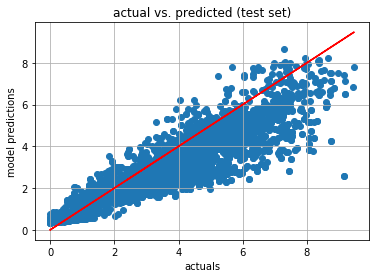

In [32]:
plt.scatter(y_test,test_predictions)
plt.xlabel('actuals')
plt.ylabel('model predictions')
plt.title('actual vs. predicted (test set)')
plt.plot(y_test,y_test,'r'); plt.grid()

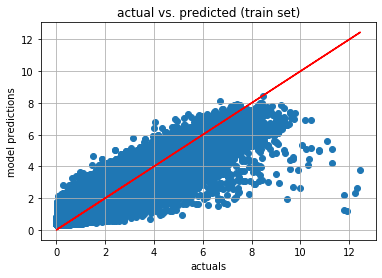

In [33]:
plt.scatter(y_train,train_predictions)
plt.xlabel('actuals')
plt.ylabel('model predictions')
plt.title('actual vs. predicted (train set)')
plt.plot(y_train,y_train,'r'); plt.grid()

### Validation of a neural network model on large populations of pools/loans

* Here we examine model performance on large populations of loans

In [35]:
df['model SMM'] = model.predict(scaler.transform(df[model_columns].drop(['SMM','asofdate'],axis=1)))

In [36]:
df['SMM x CBal'] = df['SMM']*df['CBal']
df['model SMM x CBal'] = df['model SMM']*df['CBal']
df['ppmdate'] = df['asofdate'].apply(lambda x: dt.date(int(str(x)[:4]),int(str(x)[-2:]),1))
df['Vintage'] = df['pool_issue_month'].apply(lambda x: int(str(x)[:4]))

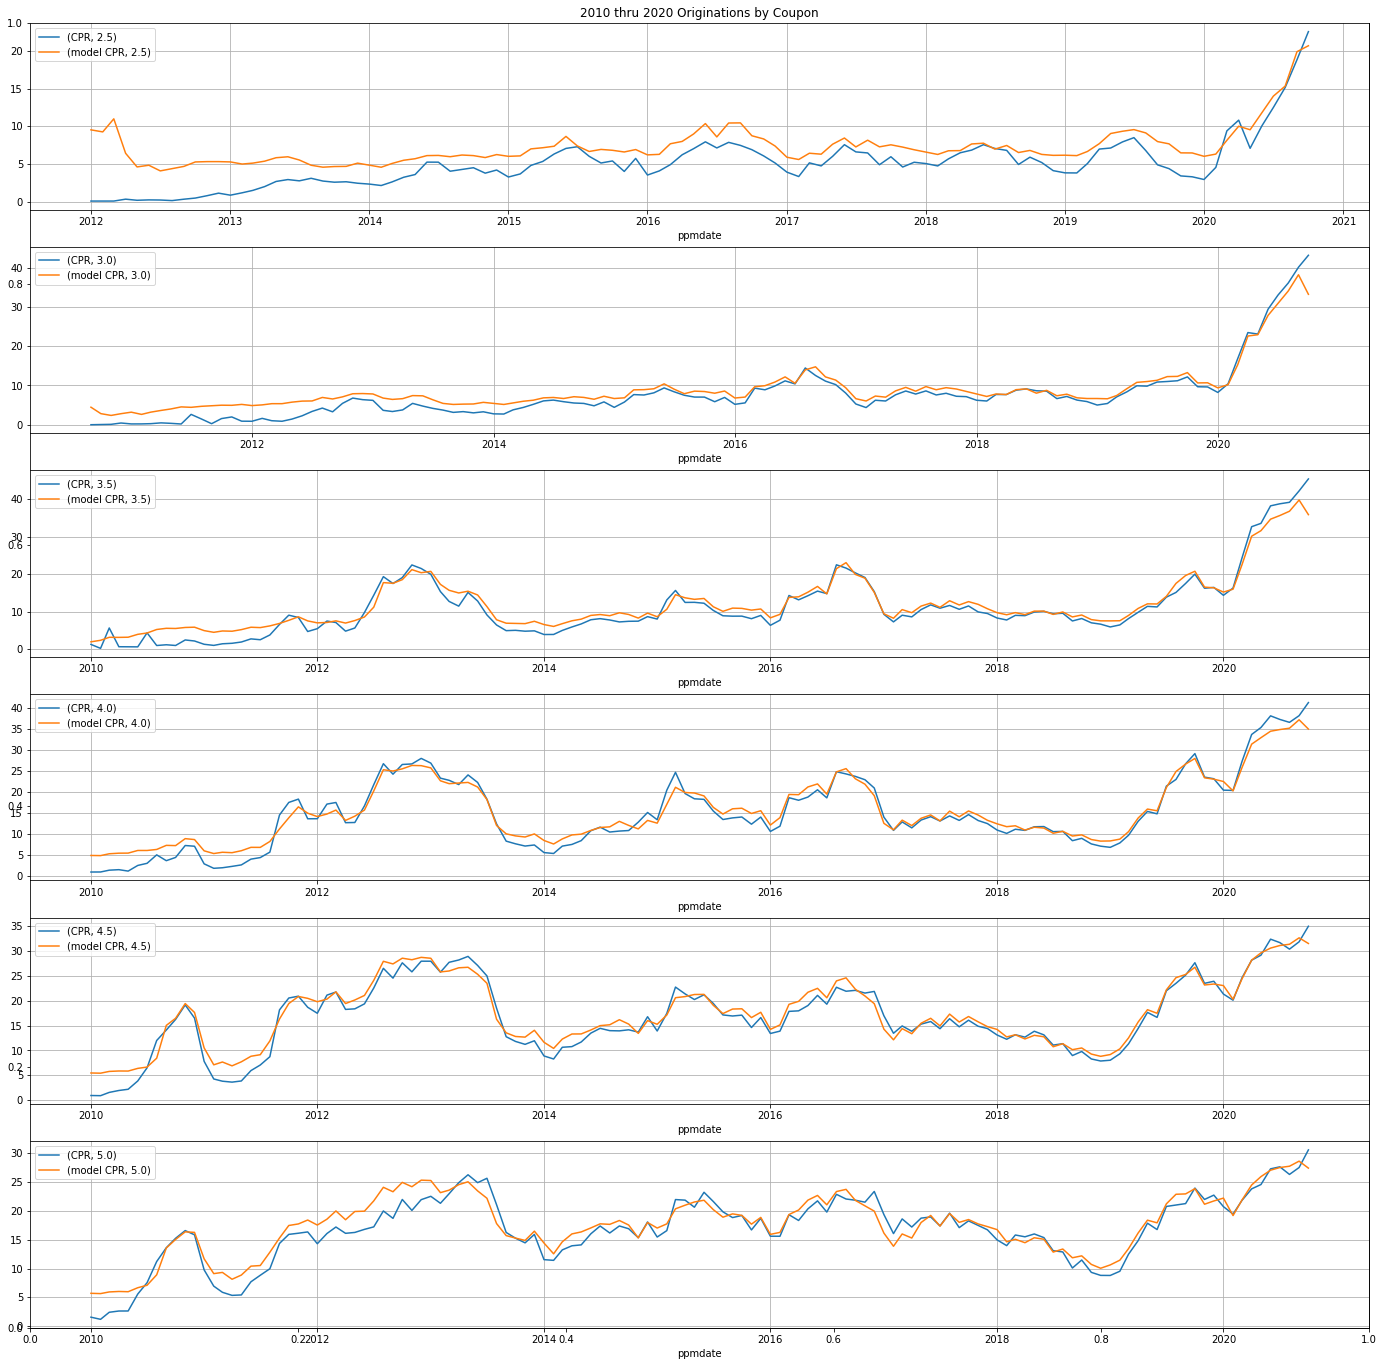

In [49]:
valReport(df,graphTitle='2010 thru 2020 Originations by Coupon',fsize=(24,24))

In [50]:
np.round(rmse_by_coupon(df[df['asofdate']<data_cutoff],col_name='2010 - 2020 Vintages NN RMSE (CPR)'),2)

,2010 - 2020 Vintages NN RMSE (CPR)
Coupon,
2.5,2.90
3.0,2.05
3.5,1.89
4.0,1.90
4.5,1.72
5.0,1.90


In [38]:
np.round(rmse_by_coupon(df[df['asofdate']>=data_cutoff],col_name='2010 - 2020 Vintages NN RMSE (CPR)'),2)

,2010 - 2020 Vintages NN RMSE (CPR)
Coupon,
2.5,1.87
3.0,9.94
3.5,9.51
4.0,6.32
4.5,3.47
5.0,3.16


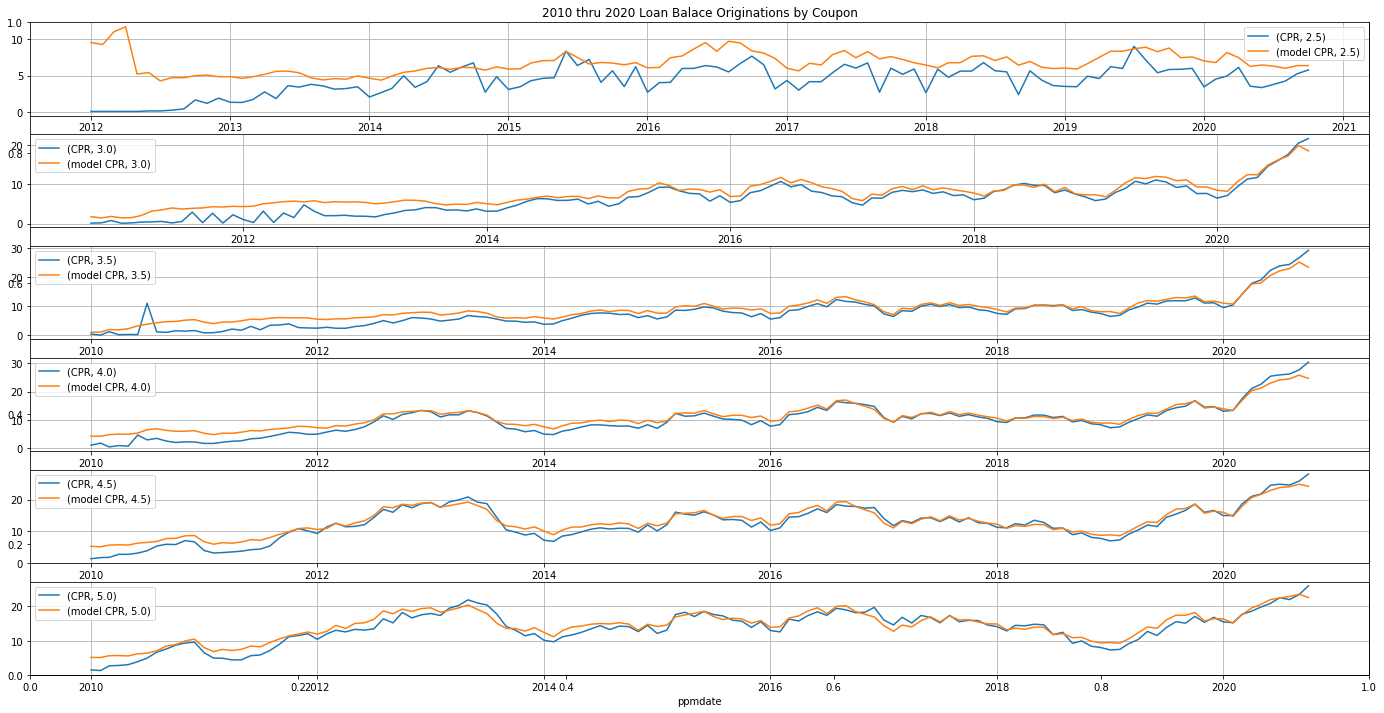

In [39]:
valReport(df[df['waols'] <= 200000],graphTitle='2010 thru 2020 Loan Balace Originations by Coupon',fsize=(24,12))

In [40]:
np.round(rmse_by_coupon(df[(df['asofdate']>=data_cutoff) & (df['waols'] <= 200000)],col_name='200k max NN RMSE (CPR)'),2)

,200k max NN RMSE (CPR)
Coupon,
2.5,0.59
3.0,3.16
3.5,5.76
4.0,5.75
4.5,3.88
5.0,3.34


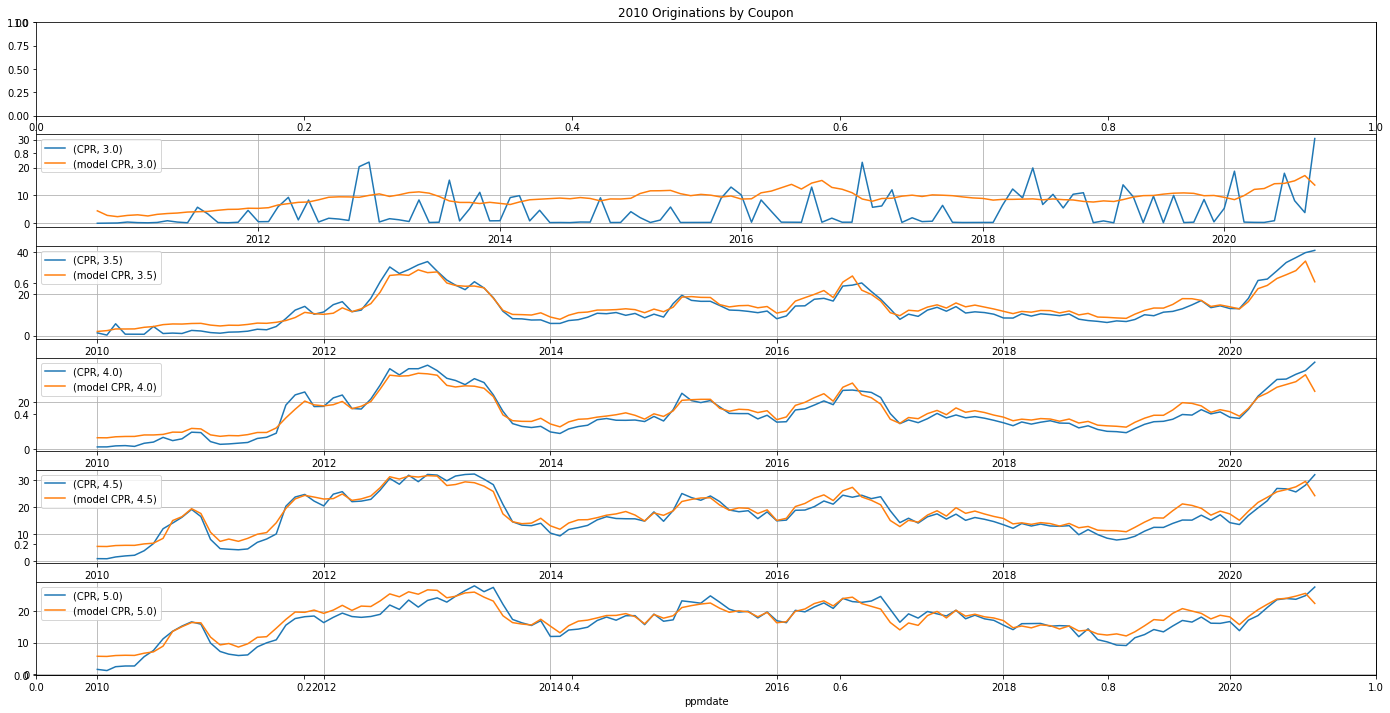

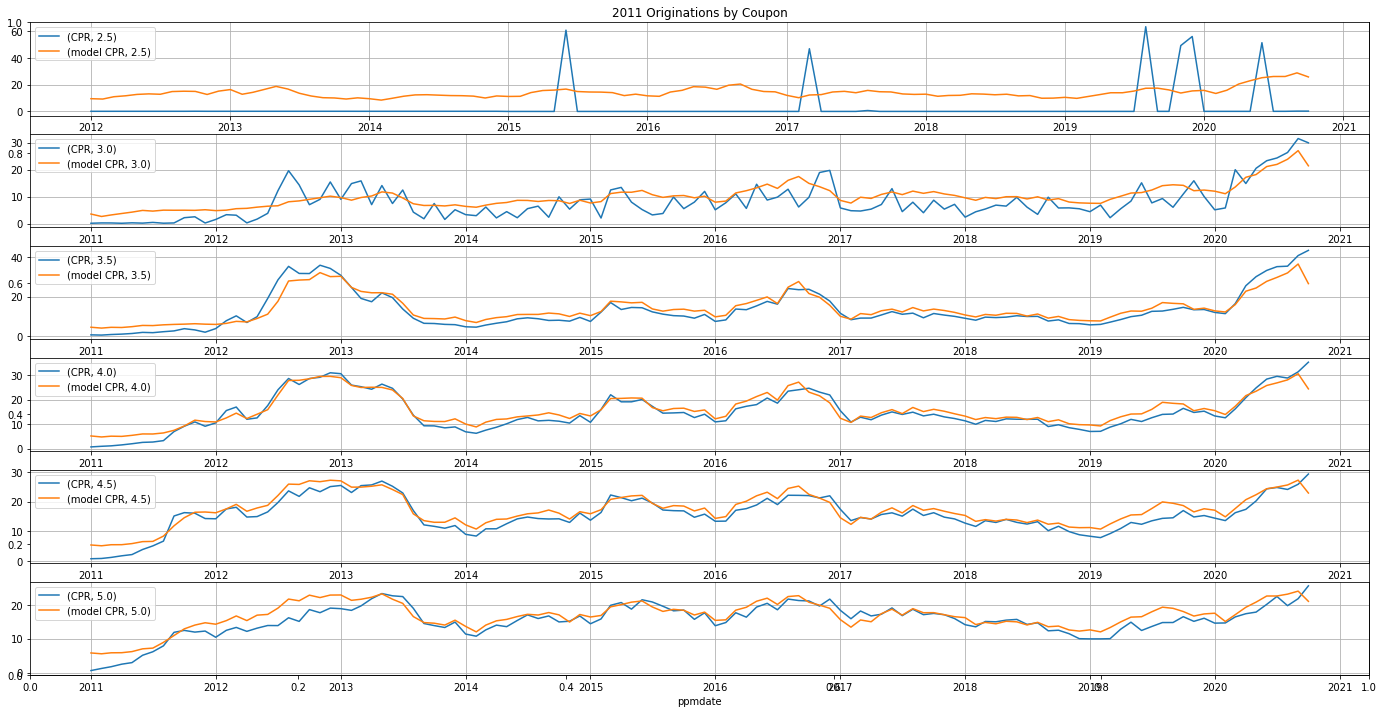

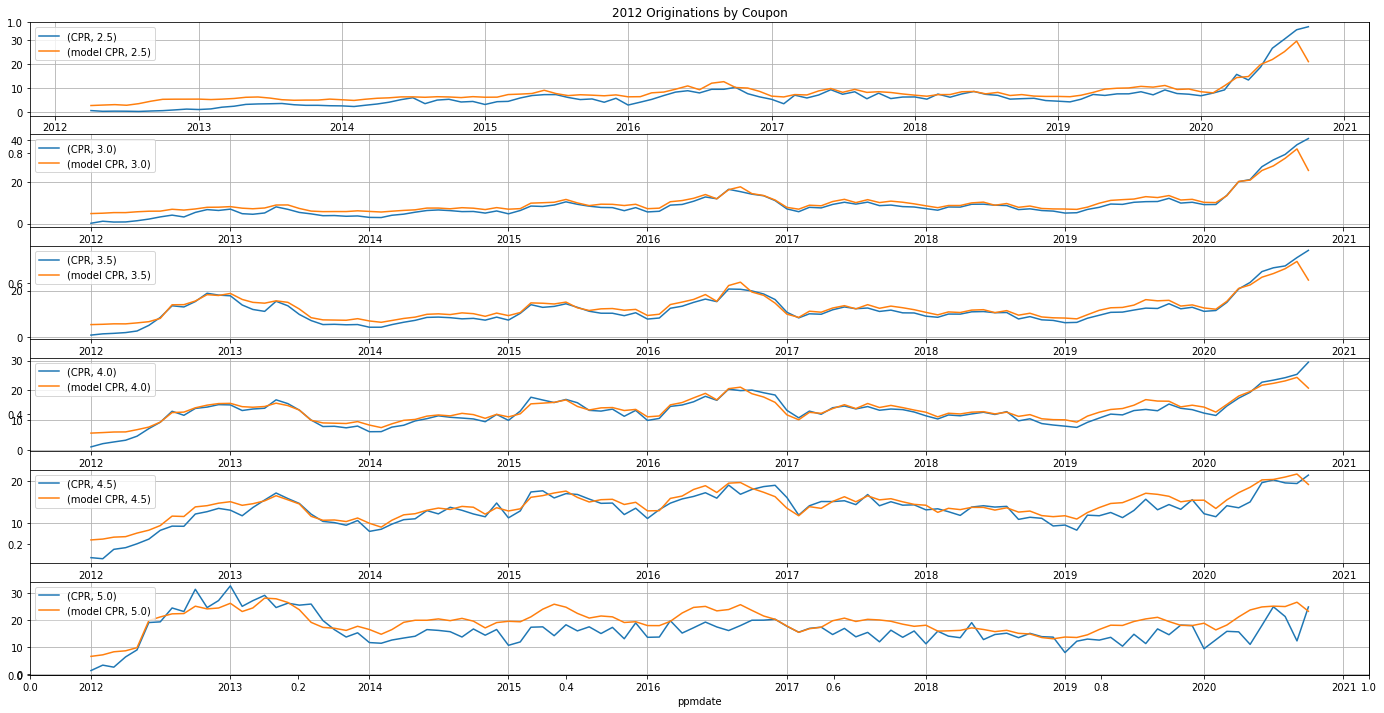

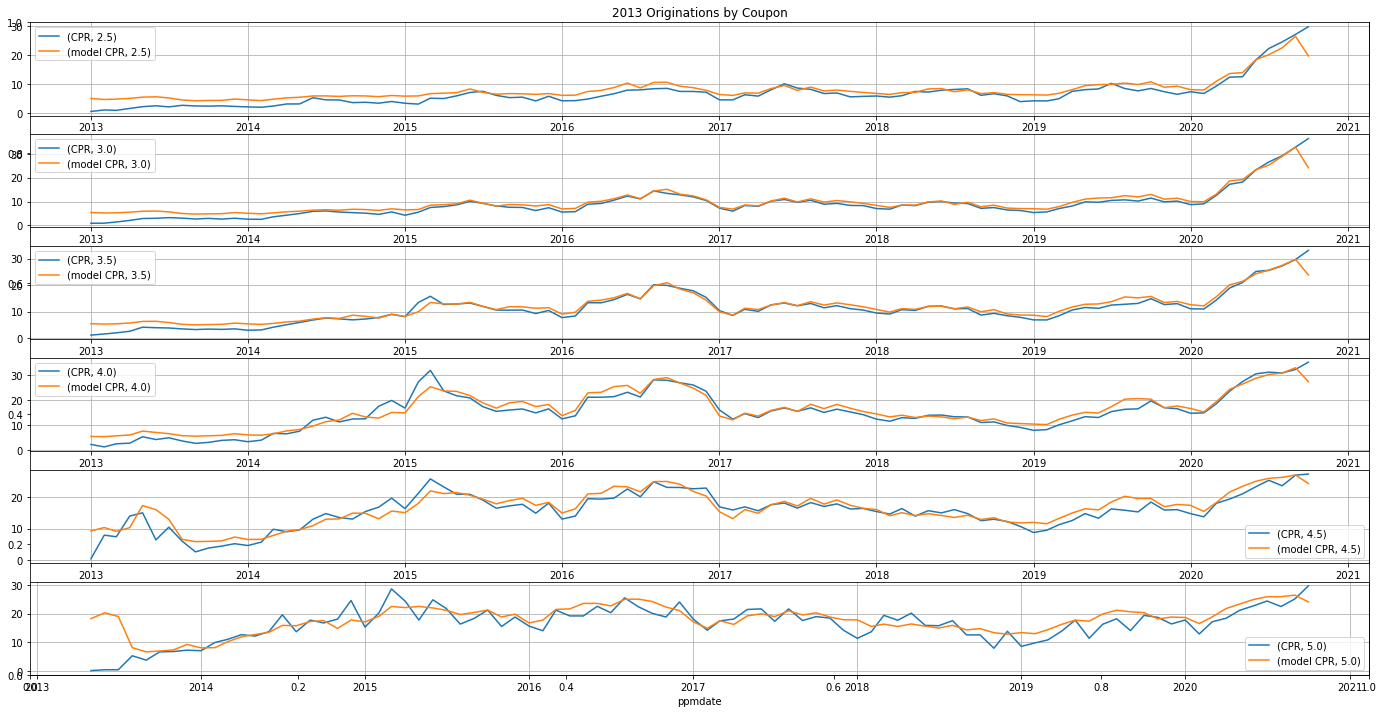

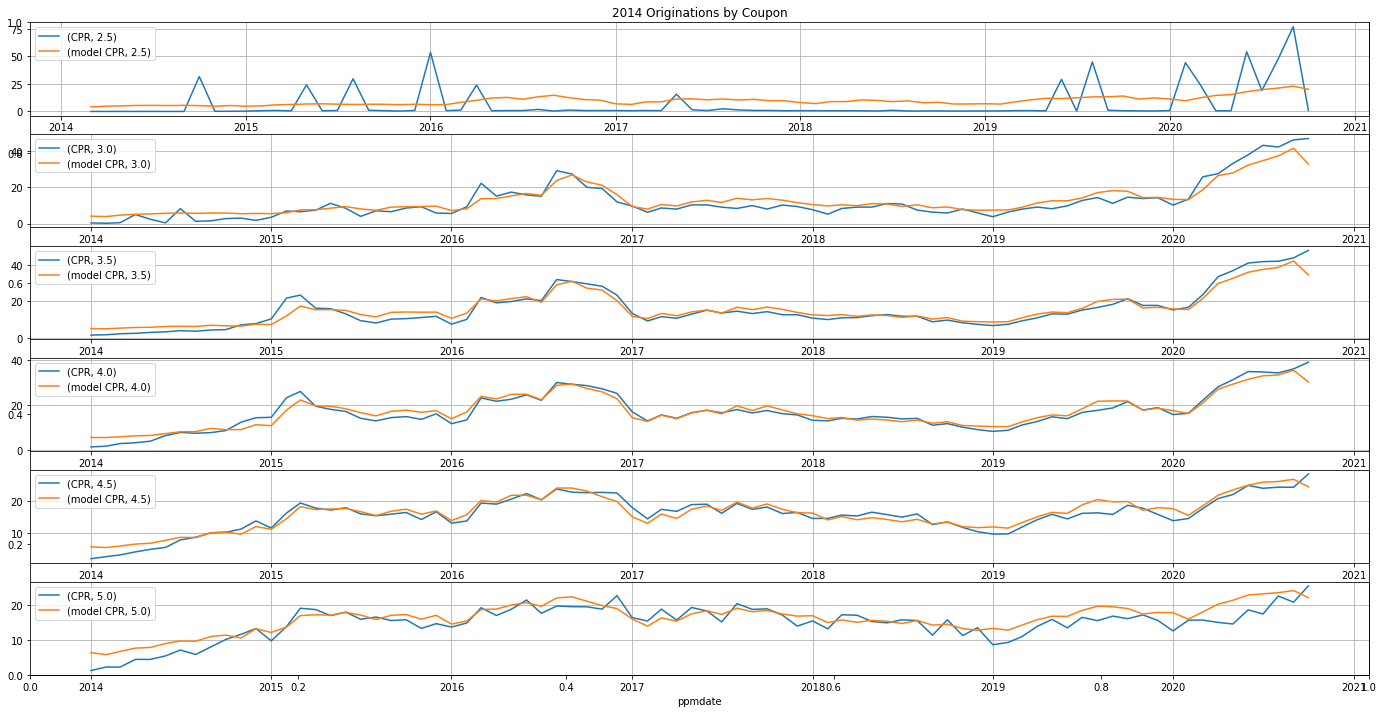

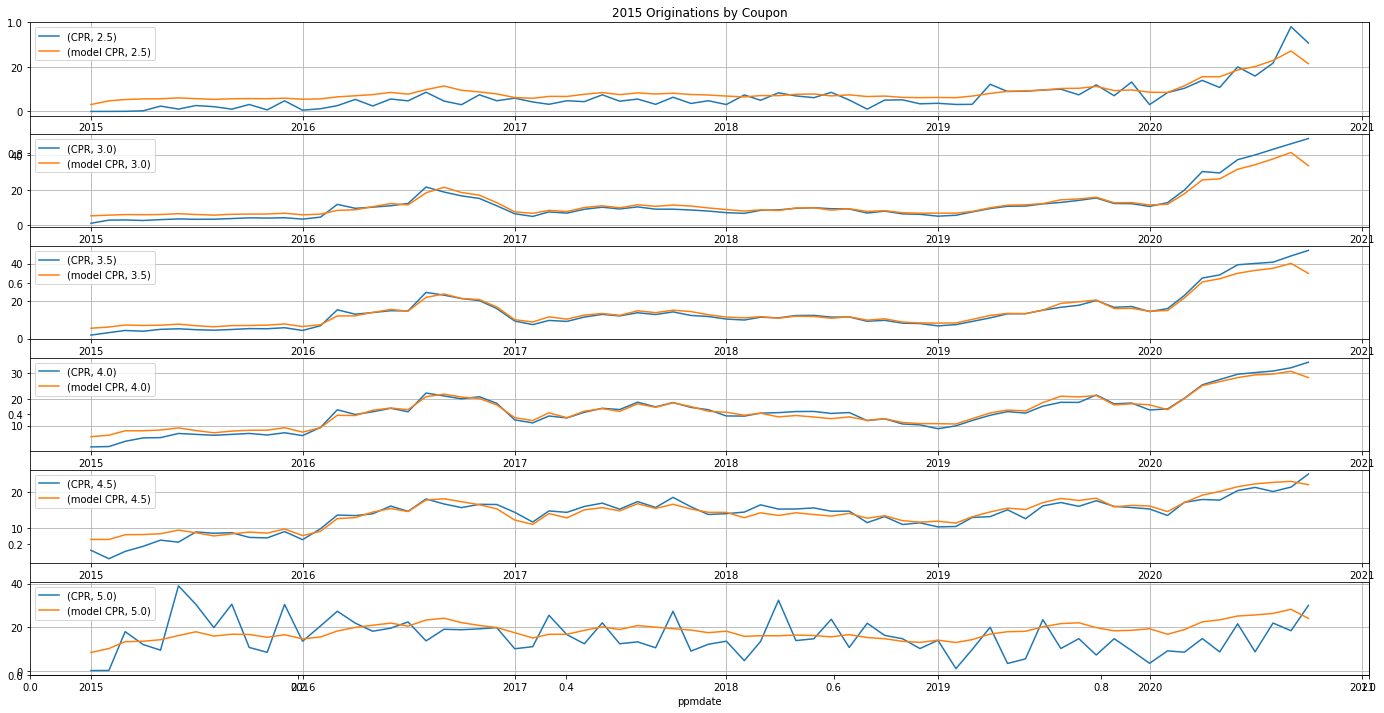

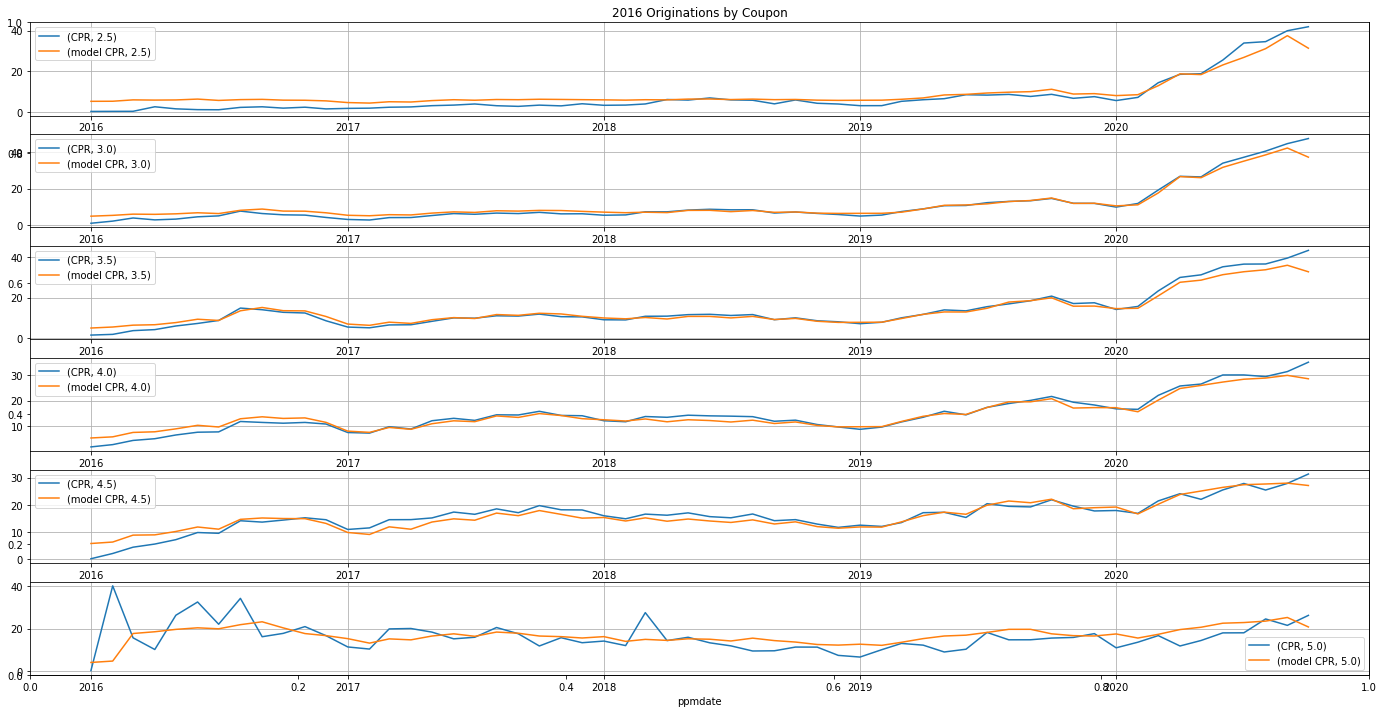

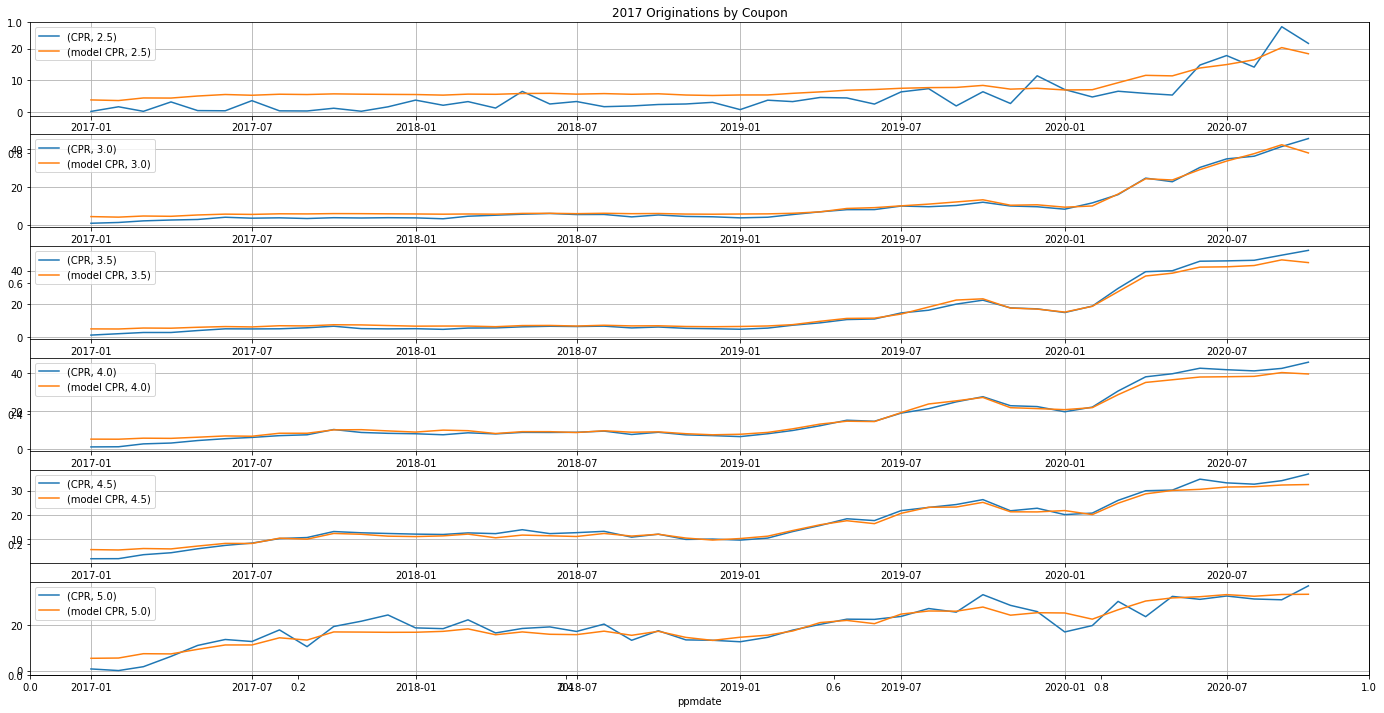

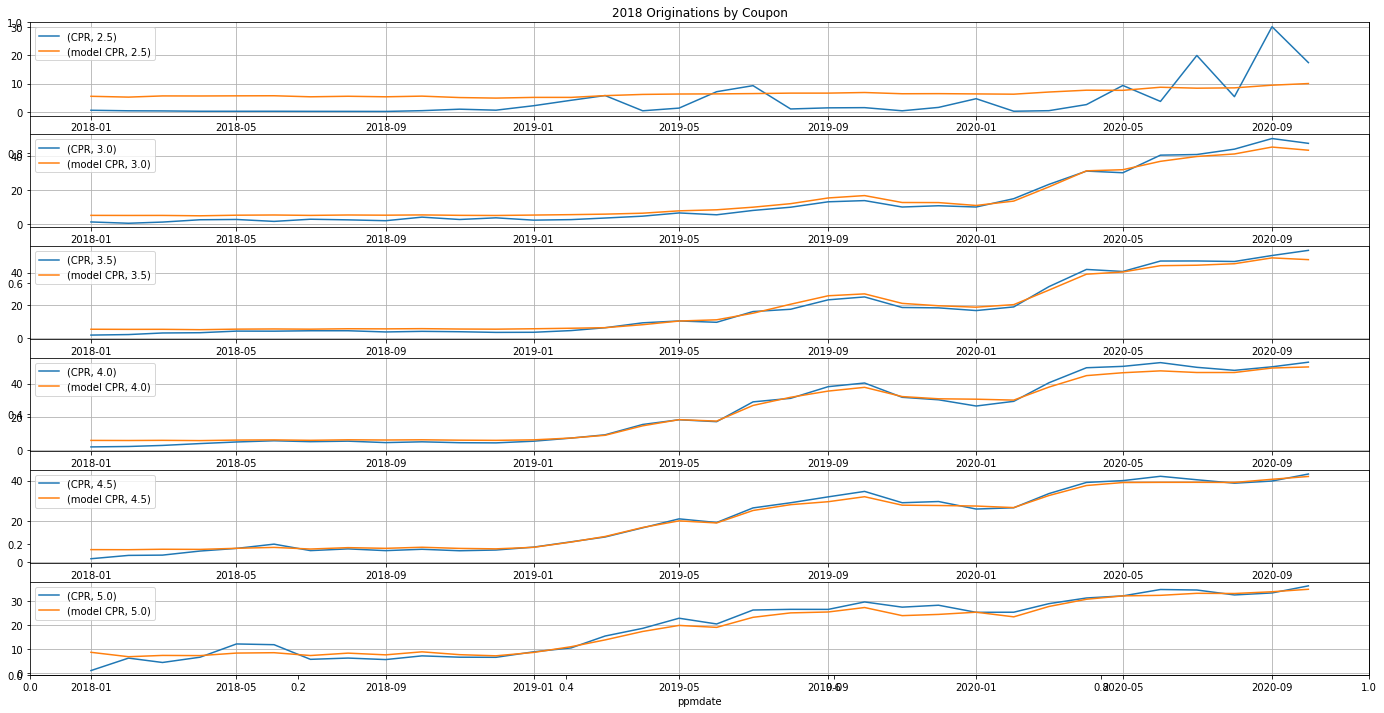

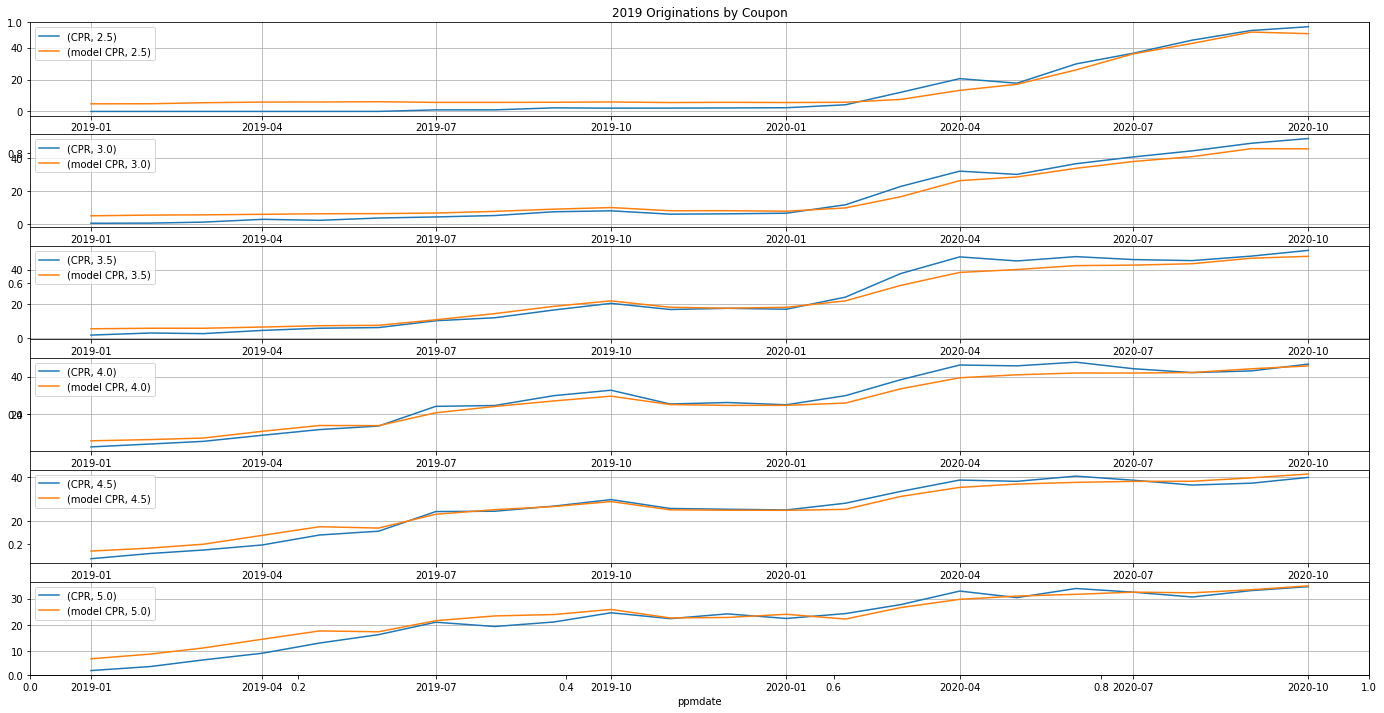

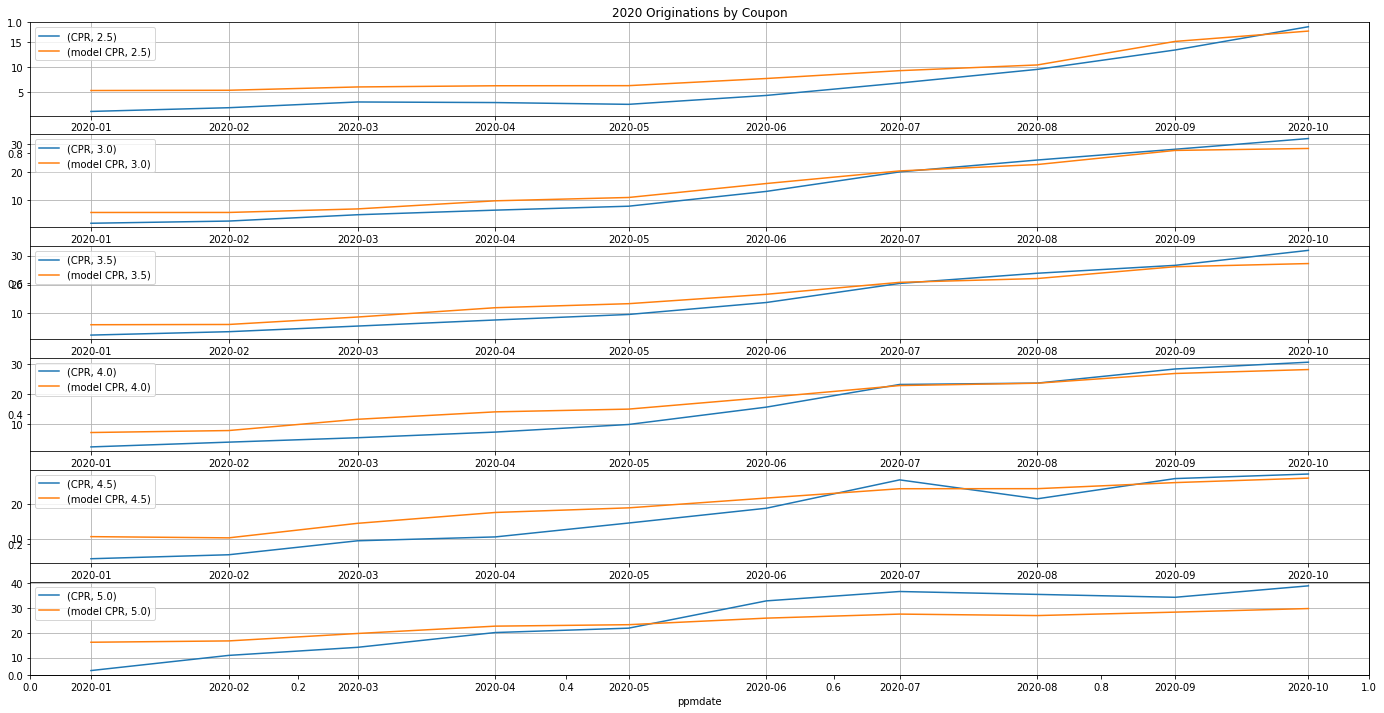

In [41]:
for vintage in [2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020]:

    valReport(df[df['Vintage'] == vintage],graphTitle=f'{vintage} Originations by Coupon',fsize=(24,12))

In [42]:
for vintage in [2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020]:

    print(np.round(rmse_by_coupon(df[(df['asofdate']>=data_cutoff) & (df['Vintage'] == vintage)],col_name=f'{vintage} NN RMSE (CPR)'),2))
    print('\n')

        2010 NN RMSE (CPR)
Coupon                    
3.0                  16.71
3.5                  15.09
4.0                  12.53
4.5                   7.78
5.0                   5.18


        2011 NN RMSE (CPR)
Coupon                    
2.5                  25.53
3.0                   8.50
3.5                  16.76
4.0                  10.86
4.5                   6.39
5.0                   4.57


        2012 NN RMSE (CPR)
Coupon                    
2.5                  14.67
3.0                  15.31
3.5                  12.74
4.0                   8.72
4.5                   2.22
5.0                   1.60


        2013 NN RMSE (CPR)
Coupon                    
2.5                  10.09
3.0                  12.26
3.5                   9.29
4.0                   7.83
4.5                   3.03
5.0                   5.63


        2014 NN RMSE (CPR)
Coupon                    
2.5                  19.17
3.0                  14.10
3.5                  13.50
4.0                 

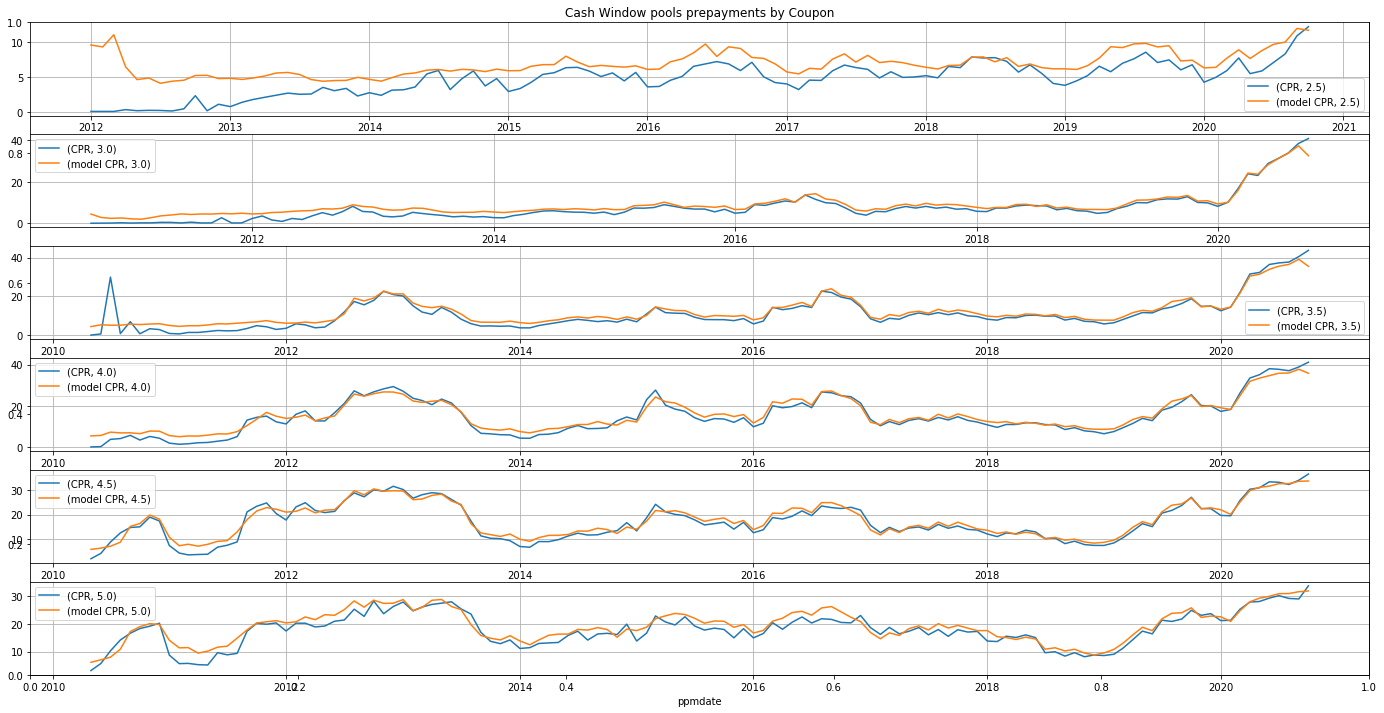

In [43]:
valReport(df[(df['%CashWindow'] == 100) & (df['Vintage'] > 2009)],graphTitle='Cash Window pools prepayments by Coupon',fsize=(24,12),lcoup=2.5,hcoup=5)

In [44]:
np.round(rmse_by_coupon(df[(df['asofdate']>=data_cutoff) & (df['%CashWindow'] == 100)],col_name='Cash Window - NN RMSE (CPR)'),2)

,Cash Window - NN RMSE (CPR)
Coupon,
2.5,0.49
3.0,8.28
3.5,8.23
4.0,5.35
4.5,2.84
5.0,1.85


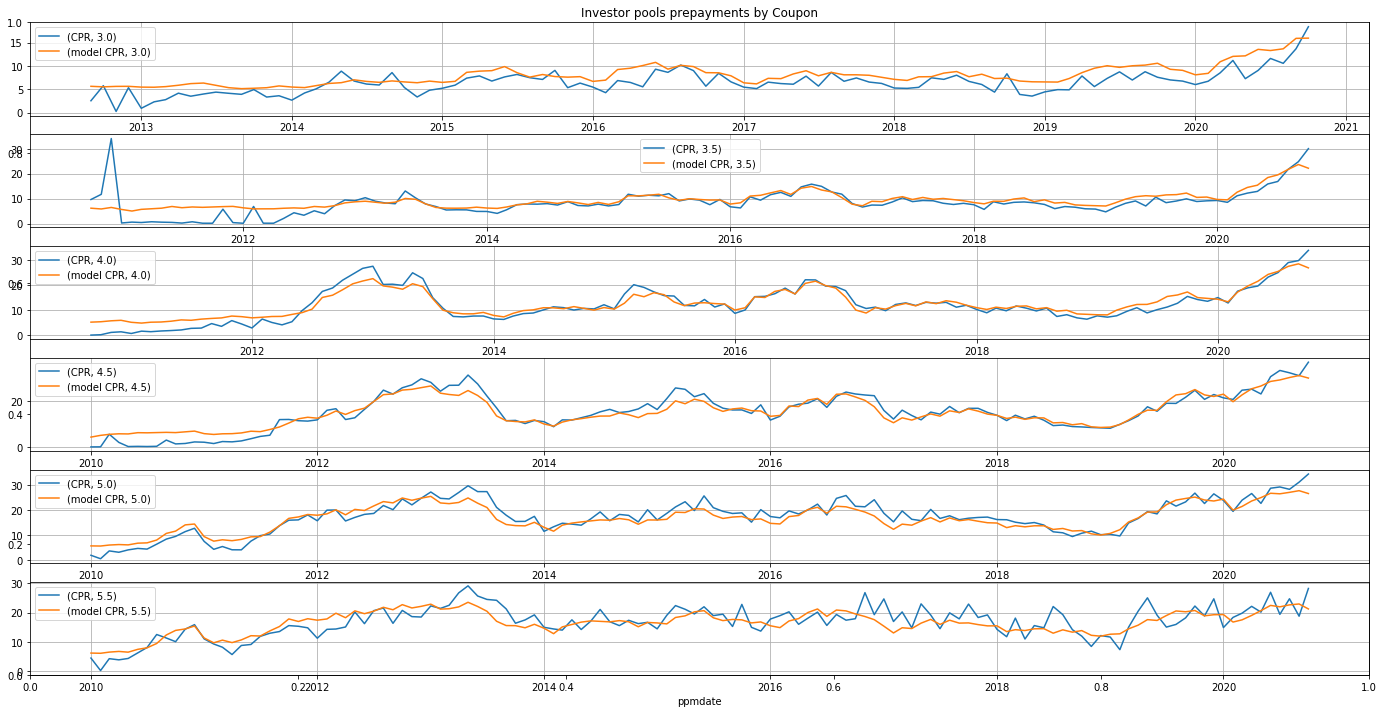

In [45]:
valReport(df[(df['OccPct_investor'] > 99) & (df['Vintage'] > 2009)],graphTitle='Investor pools prepayments by Coupon',fsize=(24,12),lcoup=3,hcoup=5.5)

In [46]:
np.round(rmse_by_coupon(df[(df['asofdate']>=data_cutoff) & (df['OccPct_investor'] > 99)],col_name='Investor - NN RMSE (CPR)'),2)

,Investor - NN RMSE (CPR)
Coupon,
2.5,2.24
3.0,2.44
3.5,7.87
4.0,6.98
4.5,6.93
5.0,7.82


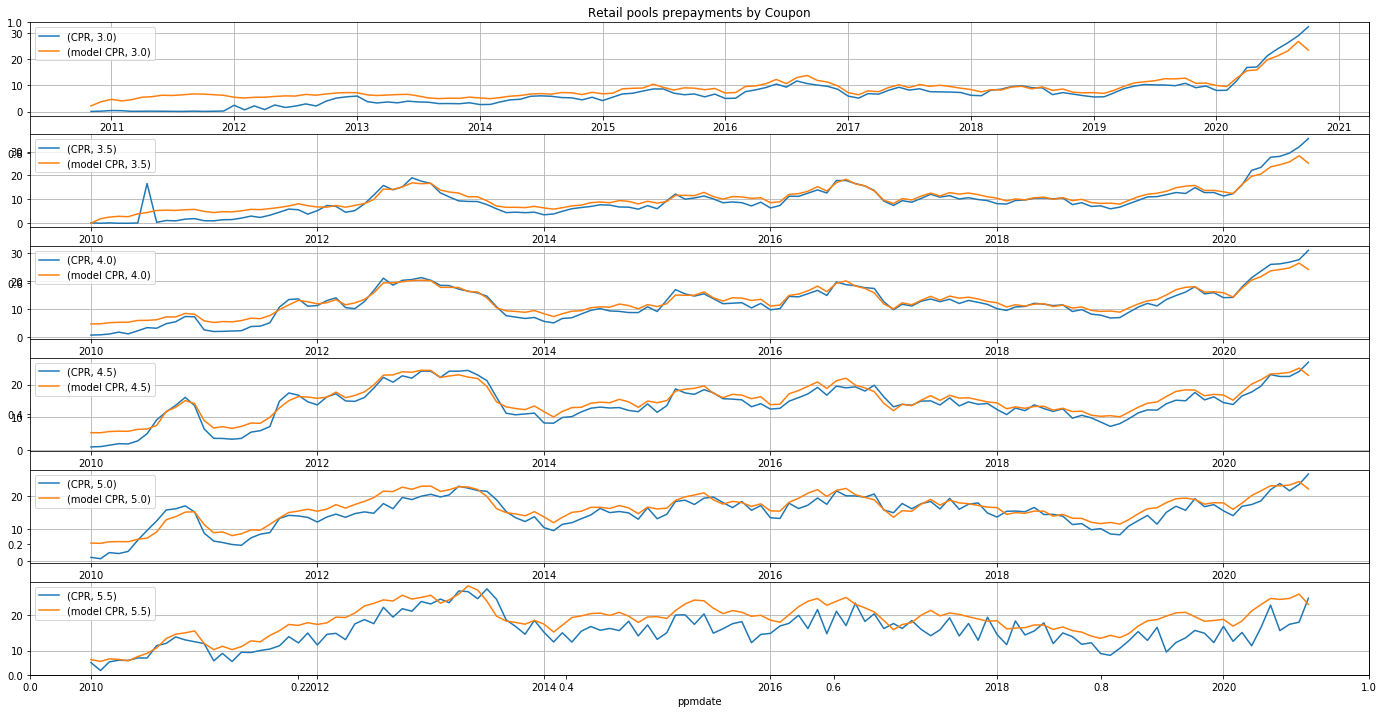

In [47]:
valReport(df[(df['PctChannel_Retail'] > 99) & (df['Vintage'] > 2009)],graphTitle='Retail pools prepayments by Coupon',fsize=(24,12),lcoup=3,hcoup=5.5)

In [48]:
np.round(rmse_by_coupon(df[(df['asofdate']>=data_cutoff) & (df['PctChannel_Retail'] > 99)],col_name='Retail - NN RMSE (CPR)'),2)

,Retail - NN RMSE (CPR)
Coupon,
2.5,0.75
3.0,8.97
3.5,10.32
4.0,6.84
4.5,4.03
5.0,4.61


### Save the neural network prepayment model in .h5 format

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model_name

#### Uncomment the line below if you would like to save

In [ ]:
# model.save(model_name)

#### Uncomment the line below if you would like to load the model saved in Git repository

In [ ]:
# model = load_model('nn-ppm-from-csv.h5')

#### Section below is still under development

In [ ]:
# import kerastuner as kt 

In [ ]:
# def model_builder(hp):

#     model = Sequential()
    
#     #input layer / first hidden layer

#     first_layer_neurons      = hp.Int('layer_1_units', min_value=32, max_value = 1024, step = 32)
#     first_layer_dropout_rate = hp.Float('layer_1_dropout_rate', min_value = 0, max_value = 0.5, step = 0.1)

#     model.add(Dense(first_layer_neurons, input_dim=X_train.shape[1], activation='relu'))
#     model.add(Dropout(first_layer_dropout_rate))

#     # 2nd layer
#     second_layer_neurons      = hp.Int('layer_2_units', min_value=128, max_value = 512, step = 32)
#     second_layer_dropout_rate = hp.Float('layer_2_dropout_rate', min_value = 0, max_value = 0.5, step = 0.1)

#     model.add(Dense(second_layer_neurons, activation='relu'))
#     model.add(Dropout(second_layer_dropout_rate))

#     # 3rd layer
#     third_layer_neurons      = hp.Int('layer_3_units', min_value=64, max_value = 256, step = 32)
#     third_layer_dropout_rate = hp.Float('layer_3_dropout_rate', min_value = 0, max_value = 0.5, step = 0.1)

#     model.add(Dense(third_layer_neurons, activation='relu'))
#     model.add(Dropout(third_layer_dropout_rate))

#     # 4th layer
#     forth_layer_neurons      = hp.Int('layer_4_units', min_value=32, max_value = 128, step = 32)
#     forth_layer_dropout_rate = hp.Float('layer_4_dropout_rate', min_value = 0, max_value = 0.5, step = 0.1)

#     model.add(Dense(forth_layer_neurons, activation='relu'))
#     model.add(Dropout(forth_layer_dropout_rate))

#     #output layer
#     model.add(Dense(1, activation='relu')) # relu activation is perfect here, because SMM cannot be negative

#     model.compile(optimizer='adam', loss='mse')
#     #model.compile(optimizer='rmsprop', loss='mse')    

#     return model

In [ ]:
# tuner = kt.Hyperband(model_builder,
#                      objective='val_loss',
#                      max_epochs=10,
#                      hyperband_iterations=2,
#                      directory=os.path.normpath('C:/'),
#                      project_name='nn_ppm_model-' + dt.datetime.now().strftime('%Y-%M-%d-%H-%M-%S'))

In [ ]:
# tuner.search(x=X_train,
#              y=y_train,
#              validation_data=(X_test,y_test),
#              batch_size=1024,
#              epochs=10)

In [ ]:
# best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

In [ ]:
# model = tuner.hypermodel.build(best_hps)

In [ ]:
# model.summary()

In [ ]:
# tuner.results_summary()